In [1]:
import itertools as it
import random
import numpy as np
import math
from math import radians, sqrt, atan2, sin, cos, asin
import pandas as pd
import matplotlib.pyplot as plt
import networkx as nx
import geopandas as gpd

In [2]:
class TSP:
    def __init__(self, shape_file, csv_file, size, city_col, lat_col, lon_col):
        self.csv_file = pd.read_csv(csv_file)
        self.size = size
        self.city_col = city_col
        self.lat_col = lat_col
        self.lon_col = lon_col
        self.shape_file = shape_file
        self.dfCities = self.select_cities()
        self.city_names = list(self.dfCities.iloc[:len(self.dfCities), 0])
        self.dfMatrix = self.create_datamatrix()
        self.distance_matrix = self.dfMatrix.to_numpy()

    def show_csv(self):
        return self.csv_file

    def select_cities(self):
        return self.csv_file.iloc[:self.size, [self.city_col, self.lat_col, self.lon_col]]

    def create_datamatrix(self):
        matrix = []
        rows = len(self.dfCities)
        R = 6371.0
        for x in range(rows):
            lat1, lon1 = radians(self.dfCities.iloc[x, 1]), radians(self.dfCities.iloc[x, 2])
            for y in range(rows):
                lat2, lon2 = radians(self.dfCities.iloc[y, 1]), radians(self.dfCities.iloc[y, 2])
                dlat = lat2 - lat1
                dlon = lon2 - lon1
                a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2
                c = 2 * asin(sqrt(a))
                distance = round(R * c)
                matrix.append(distance)

        matrix = np.array(matrix)
        matrix = matrix.reshape(rows,rows)
        city_dataframe = pd.DataFrame(matrix, index = self.city_names, columns = self.city_names)
        return city_dataframe

    def convert_tour(self, tour):
        converted_tour = []
        for i in tour:
            converted_tour.append(self.city_names[i])
        return converted_tour

    def revert_tour(self, tour):
        reverted_tour = []
        for i in tour:
            reverted_tour.append(self.city_names.index(i))
        return reverted_tour

    def tour_distance(self,tour):
        reverted_tour = self.revert_tour(tour)
        matrix = self.distance_matrix
        distance = 0
        for i in range(len(reverted_tour) -1):
            distance += matrix[reverted_tour[i],reverted_tour[i+1]]
        return distance

    def create_random_tour(self):
        city_names = self.city_names
        temp = city_names[1:]
        random.shuffle(temp)
        random_tour = [city_names[0]] + temp + [city_names[0]]
        return random_tour

    def create_coordinates(self):
        dfCities = self.select_cities()
        lat, lng = dfCities.iloc[:len(dfCities), 1], dfCities.iloc[:len(dfCities), 2]
        city_names = self.city_names
        coordinates = tuple(zip(lng, lat))
        city_coordinates = {}
        for i in range(len(city_names)):
            city_coordinates[city_names[i]] = coordinates[i]
        return city_coordinates

    def create_graph(self):
        city_coordinates = self.create_coordinates()
        graph = nx.DiGraph()
        for name, coords in city_coordinates.items():
            graph.add_node(name, pos = coords)
        return graph

    def create_edges(self,graph, tour):
        for i in range(len(tour) -1):
            graph.add_edge(tour[i], tour[i+1])
        return graph

    def draw_graph_map(self, graph):
        city_names = self.city_names

        tsp_map = gpd.read_file(self.shape_file)
        tsp_map.plot(figsize = (10,10), edgecolor = 'black', facecolor = 'lightgrey', linewidth = 0.2).axis('off')

        pos = nx.get_node_attributes(graph, 'pos')
        nx.draw(graph, pos = pos, with_labels = False, node_color = 'blue', edge_color = 'black', node_size = 20, font_size = 5)
        nx.draw_networkx_nodes(graph, pos, nodelist = [city_names[0]], node_color = 'yellow', node_size = 20)

        min_x, min_y, max_x, max_y = tsp_map.total_bounds
        plt.xlim(min_x, max_x)
        plt.ylim(min_y, max_y)
        plt.show()

    def tour_graph(self, tour):
        graph = self.create_graph()
        graph = self.create_edges(graph, tour)
        draw_graph = self.draw_graph_map(graph)
        return draw_graph

    def display_tour(self, tour, distance):
        graph = self.tour_graph(tour)
        print(tour)
        print(distance)

    def MST(self):
        n = len(self.city_names)
        graph = nx.Graph()
        coordinates = list(self.create_coordinates().values())
        for i in range(n):
            graph.add_node(self.city_names[i], pos = coordinates[i])
            for j in range(i+1, n):
                graph.add_edge(self.city_names[i], self.city_names[j], weight = self.distance_matrix[i][j])
        mst_graph = nx.minimum_spanning_tree(graph)
        weight = sum(d['weight'] for u, v, d in mst_graph.edges(data=True))
        draw_graph = self.draw_graph_map(mst_graph)
        print(weight)


    def nearest_neighbor(self, show_map = False):
        matrix = self.distance_matrix
        city_list = list(range(len(matrix)))
        starting_city = city_list[0]
        current_city = starting_city
        visited = [starting_city]
        distance = 0

        for i in range(len(matrix) - 1):
            nearest_city_distance, nearest_city = min([(distance,city) for city, distance in enumerate(matrix[current_city]) if city not in visited])
            distance += nearest_city_distance
            current_city = nearest_city
            visited.append(current_city)

        distance += matrix[current_city, starting_city]
        visited.append(starting_city)
        tour = self.convert_tour(visited)

        if show_map:
            self.display_tour(tour, distance)
        else:
            return tour, distance

    @staticmethod
    def two_opt_swap(i, j, tour):
        opt_tour = tour.copy()
        return opt_tour[:i+1] + list(reversed(opt_tour[i+1:j+1])) + opt_tour[j+1:]

    def two_opt(self, tour, show_map = False):
        current_tour = tour.copy()
        current_distance = self.tour_distance(current_tour)
        for i in range(len(tour)):
            for j in range(i+1, len(tour) -1):
                if j - i == 1:
                    continue
                two_opt_tour = self.two_opt_swap(i, j, current_tour)
                two_opt_distance = self.tour_distance(two_opt_tour)

                if two_opt_distance < current_distance:
                    current_tour = two_opt_tour
                    current_distance = two_opt_distance

        if show_map:
            self.display_tour(current_tour, current_distance)
        else:
            return current_tour, current_distance


    def simulated_annealing(self,tour, temperature, cooling_rate, final_temp, show_map = False):
        current_tour = tour.copy()
        current_distance = self.tour_distance(current_tour)
        best_tour = current_tour
        best_distance = current_distance
        n = len(current_tour) - 1
        while temperature > final_temp:
            i, j = sorted(random.sample(range(n),2))
            new_tour = self.two_opt_swap(i, j, current_tour)
            new_distance = self.tour_distance(new_tour)

            if new_distance < current_distance or random.random() < np.exp(-(new_distance - current_distance) / temperature):
                current_tour = new_tour
                current_distance = new_distance

                if current_distance < best_distance:
                    best_tour = current_tour
                    best_distance = current_distance

            temperature -= cooling_rate

        sa_tour = best_tour

        if show_map:
            self.display_tour(sa_tour, best_distance)
        else:
            return sa_tour, best_distance

    def genetic_algorithm(self, population_size, generations, mutation_rate, show_map = False):
        def create_population(population_size):
            population = []
            city_names = self.city_names
            temp_list = city_names[1:]
            for i in range(population_size):
                random.shuffle(temp_list)
                temp_list_2 = [city_names[0]] + temp_list + [city_names[0]]
                population.append(temp_list_2)
            return population

        def create_survivors(population):
            survivors = population[:len(population)//2]
            return survivors

        def create_mutation(offspring, mutation_rate):
            n = len(offspring) - 1
            if random.random() < mutation_rate:
                i,j = sorted(random.sample(range(n),2))
                offspring = self.two_opt_swap(i, j, offspring)
            return offspring

        def crossover(survivors, mutation_rate):
            parent_1, parent_2 = random.sample(survivors, 2)
            parent_1, parent_2 = parent_1[1:-1], parent_2[1:-1]
            size = len(parent_1)
            start, end = random.sample(range(size -1), 2)
            temp_1 = parent_1[start:end]
            temp_2 = [i for i in parent_2 if i not in temp_1]
            offspring = [None] * size
            offspring[start:end] = temp_1
            k = 0
            for i in range(len(offspring)):
                if offspring[i] == None:
                    offspring[i] = temp_2[k]
                    k += 1
            offspring = [self.city_names[0]] + offspring + [self.city_names[0]]
            offspring = create_mutation(offspring, mutation_rate)
            return offspring

        best_tours = []
        current_population = create_population(population_size)
        for i in range(generations):
            current_population = sorted(current_population, key = lambda tour: self.tour_distance(tour))
            best_tours.append(min(current_population, key = lambda tour: self.tour_distance(tour)))
            survivors = create_survivors(current_population)
            new_population = []
            while(len(new_population)) < population_size:
                offspring = crossover(survivors, mutation_rate)
                new_population.append(offspring)
            current_population = new_population

        ga_tour = min(best_tours, key = lambda tour: self.tour_distance(tour))
        ga_distance = self.tour_distance(ga_tour)

        if show_map:
            self.display_tour(ga_tour, ga_distance)
        else:
            return ga_tour, ga_distance

In [3]:
ro_csv = 'ro.csv'
ro_shapefile = 'Shapefiles/RO Shapefiles/ro.shp'
ro_tsp = TSP(ro_shapefile, ro_csv, 20, 0, 1, 2)

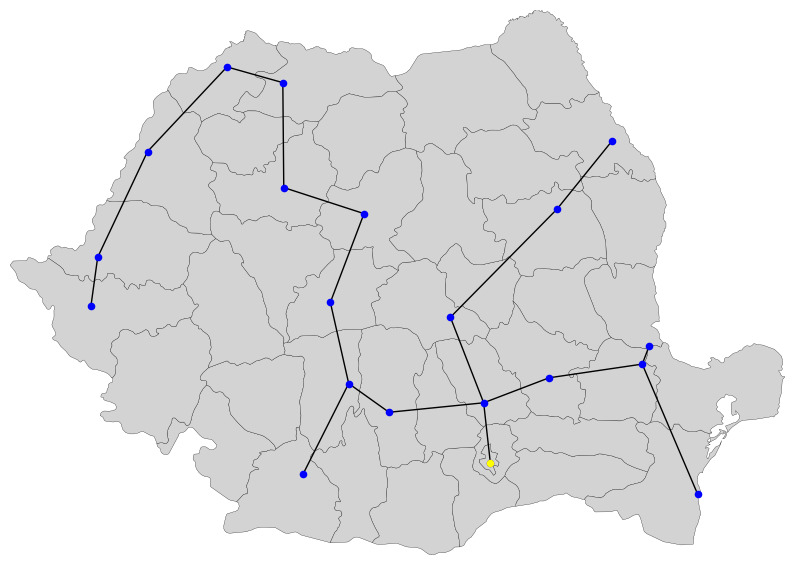

1575


In [4]:
ro_tsp.MST()

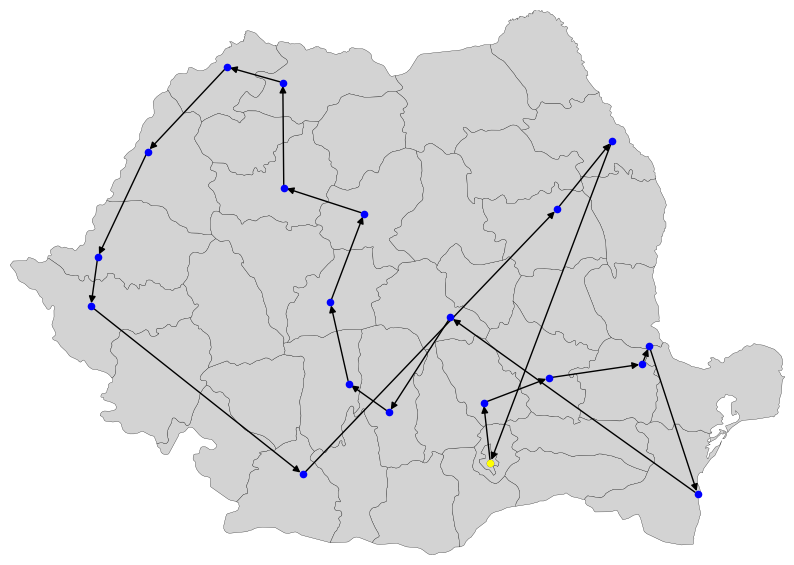

['Bucharest', 'Ploieşti', 'Buzău', 'Brăila', 'Galaţi', 'Constanţa', 'Braşov', 'Piteşti', 'Râmnicu Vâlcea', 'Sibiu', 'Târgu-Mureş', 'Cluj-Napoca', 'Baia Mare', 'Satu Mare', 'Oradea', 'Arad', 'Timişoara', 'Craiova', 'Bacău', 'Iaşi', 'Bucharest']
2499


In [5]:
ro_tsp.nearest_neighbor(show_map = True)
nn_tour, nn_distance = ro_tsp.nearest_neighbor(show_map = False)

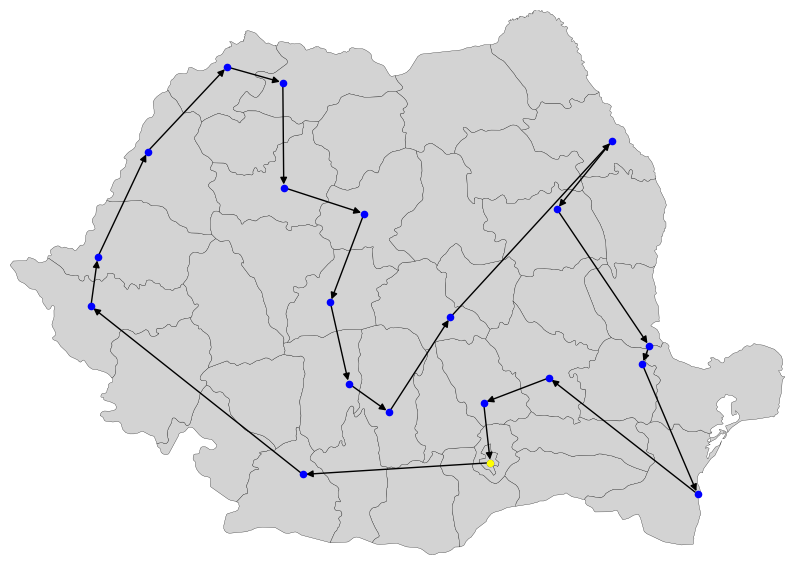

['Bucharest', 'Craiova', 'Timişoara', 'Arad', 'Oradea', 'Satu Mare', 'Baia Mare', 'Cluj-Napoca', 'Târgu-Mureş', 'Sibiu', 'Râmnicu Vâlcea', 'Piteşti', 'Braşov', 'Iaşi', 'Bacău', 'Galaţi', 'Brăila', 'Constanţa', 'Buzău', 'Ploieşti', 'Bucharest']
2176


In [6]:
ro_tsp.two_opt(nn_tour, show_map = True)
two_opt_tour, two_opt_distance = ro_tsp.two_opt(nn_tour, show_map = False)

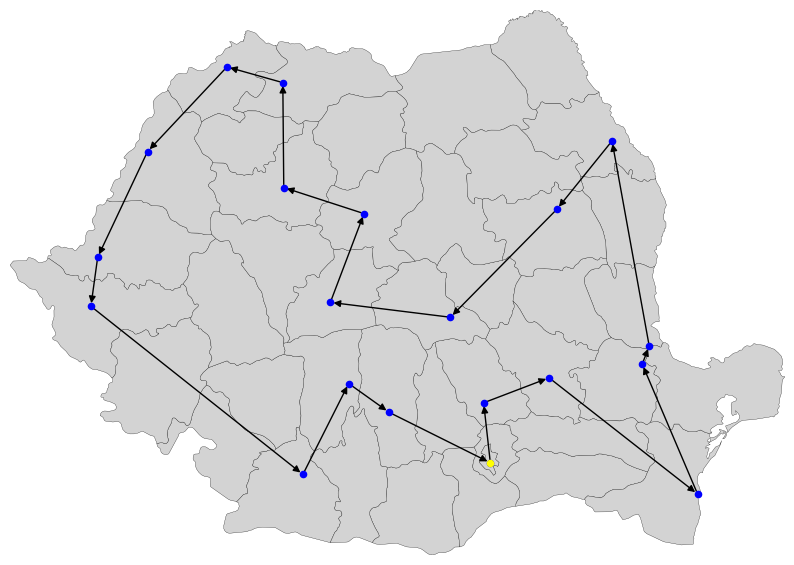

['Bucharest', 'Ploieşti', 'Buzău', 'Constanţa', 'Brăila', 'Galaţi', 'Iaşi', 'Bacău', 'Braşov', 'Sibiu', 'Târgu-Mureş', 'Cluj-Napoca', 'Baia Mare', 'Satu Mare', 'Oradea', 'Arad', 'Timişoara', 'Craiova', 'Râmnicu Vâlcea', 'Piteşti', 'Bucharest']
2087


In [7]:
ro_tsp.simulated_annealing(nn_tour, 1500, 0.001, 0, show_map = True)

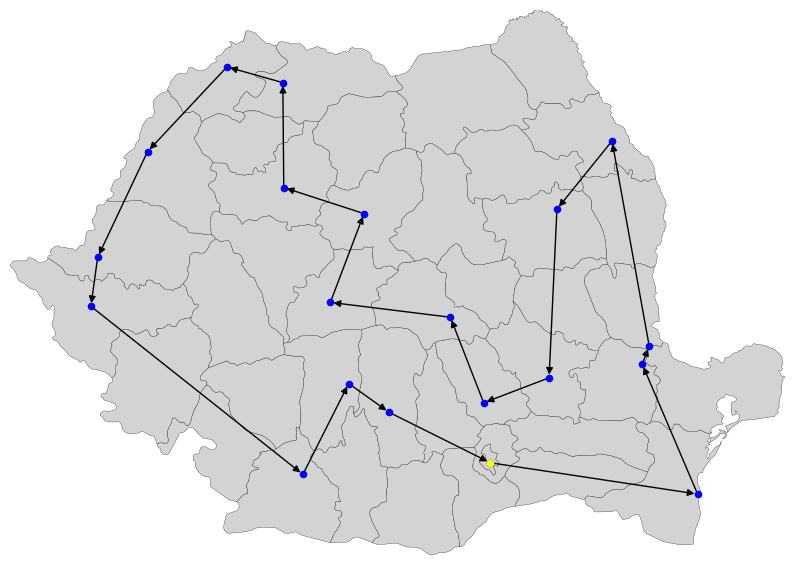

['Bucharest', 'Constanţa', 'Brăila', 'Galaţi', 'Iaşi', 'Bacău', 'Buzău', 'Ploieşti', 'Braşov', 'Sibiu', 'Târgu-Mureş', 'Cluj-Napoca', 'Baia Mare', 'Satu Mare', 'Oradea', 'Arad', 'Timişoara', 'Craiova', 'Râmnicu Vâlcea', 'Piteşti', 'Bucharest']
2156


In [8]:
ro_tsp.genetic_algorithm(1000, 1000, 0.1, show_map = True)